In [2]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'  # 그래프 높은 해상도로 출력

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False)

![detr](https://miro.medium.com/max/967/1*ROEemTct0f47Y2kDlAAF4Q.png)

# DETR

In [10]:
class DETRminimal(nn.Module):

    """ 
    DETR demo(minimal ver.) implementation

    실제 DETR 논문과의 다른점은 다음과같다.
    * sine값 대신에 P.E를 학습
    * P.E는 인풋값에 통과된다 (원랜 Attention 통과시킴)
    * Fully-Connected Bounding Box 예측기 (원랜 MLP)

    성능은 약 ~40 AP정도이며 1 batch size만 지원.

    """
    
    def __init__(self, num_classes, hidden_dim = 256, nheads = 8, num_encoder_layers = 6, num_decoder_layers = 6):
        super().__init__()

        # ResNet50을 Backbone으로 생성
        self.backbone = resnet50()
        # Backbone은 feature map(Feature Extractor) 생성에만 쓰이므로 FCL는 없애준다
        del self.backbone.fc

        # Conversion 레이어 생성
        ## 위 코드에서 FCL를 제거하고나면 마지막 output의 shape은 (None, 7, 7, 2048)
        ## input_channel : 2048 / output_channel : 256 / kernel_size : 1인 conv_layer를 추가해줌으로써 channel의 차원을 256으로 낮춰준다.
        ## 여기서 256차원은 transformer의 input_tokens의 차원이기도 하다.
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # 파이토치의 transformer를 디폴트값으로 생성
        self.transformer = nn.Transformer(hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # 예측을 위한 prediction heads에 background detection을 위한 1 extra class를 추가
        # 단, 원래 DETR에서 linear_bbox는 3-layer MLP를 사용한다.
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # Output P.E (object quries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial P.E. (원래 DETR에선 sine P.E.를 사용한다)
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):

        # 인풋값을 Resnet을 통해 순전파시킨다. (avg-pooling layer까지만)
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # 2048차원의 channel을 가진 feature map(palnes)을 256차원의 channel의 feature map으로 축소.
        h = self.conv(x)

        # P.E. 구성
        H, W = h.shape[-2 : ]
        pos = torch.cat([
                         self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
                         self.row_embed[:H].unsqueeze(1).repeat(1, W, 1)
        ], dim = -1).flatten(0, 1).unsqueeze(1)

        # transformer를 통해 순전파
        ## 1d feature sequence + P.E. 가 결합되어 transformer의 input_tokens로 쓰이고 object queries의 길이에 해당하는 output_token을 반환
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)

        # 마지막으로 transformer output을 class label과 Bbox로 사영시킨다.
        ## output_dim :  (1, len of object queries, N of classes)
        return {'pred_logits' : self.linear_class(h),
                'pred_boxes' : self.linear_bbox(h).sigmoid()}

DETR은 아주 간단하게 동작하는데, 다음과 같은 2개의 메인 구성요소들이 있다.

- Convolutional backbone - ResNet50을 사용
- Transformer - `nn.Transformer`를 기본값으로 사용

# 사전학습된 DETR의 모델 불러오기

In [11]:
detr = DETRminimal(num_classes = 91)
state_dict = torch.hub.load_state_dict_from_url(
    url = 'https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location = 'cpu',
    check_hash = True
)
detr.load_state_dict(state_dict)
detr.eval()

Downloading: "https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth" to /root/.cache/torch/hub/checkpoints/detr_demo-da2a99e9.pth


  0%|          | 0.00/79.3M [00:00<?, ?B/s]

DETRminimal(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

# DETR로 예측값 연산하기


In [12]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# standard PyTorch mean-std input image normalization
## 1. 이미지의 높이와 너비 중 작은 사이즈가 800으로 고정된다.
## 2. Tensor에 맞게끔 [w, h] format이 [h, w] format으로 변환한다.
## 3. dataset의 mean, std를 이용해 정규화가 진행된다. (-3 ~ 3)
transform = T.Compose([
                       T.Resize(800),
                       T.ToTensor(),
                       T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# output Bbox 후처리
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]

    return torch.stack(b, dim = 1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype = torch.float32)

    return b

In [13]:
def detect(im, model, transform):
    # 인풋 이미지를 mean-std normalize로 정규화 ( batch_size는 1)
    img = transform(im).unsqueeze(0)

    # minimal 버젼은 이미지 종횡비를 (0.5 ~ 2)로 제한
    # 만약, 더 높은 종횡비를 원하면 이미지를 rescale하면 된다.
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'minimal 버젼은 각 사이드 별로 1600픽셀까지만 지원합니다'

    # model을 통해 순전파
    outputs = model(img)

    # 70% 이상의 정확도를 가진 예측값만 남겨준다
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # 0과 1사이의 box들 값을 image scale로 확대한다
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    
    return probas[keep], bboxes_scaled

# DETR을 사용해보자


In [21]:
url = 'https://dimg.donga.com/wps/NEWS/IMAGE/2019/03/21/94677873.1.jpg'
im = Image.open(requests.get(url, stream = True).raw)

scores, boxes = detect(im, detr, transform)

# 모델 예측 시각화

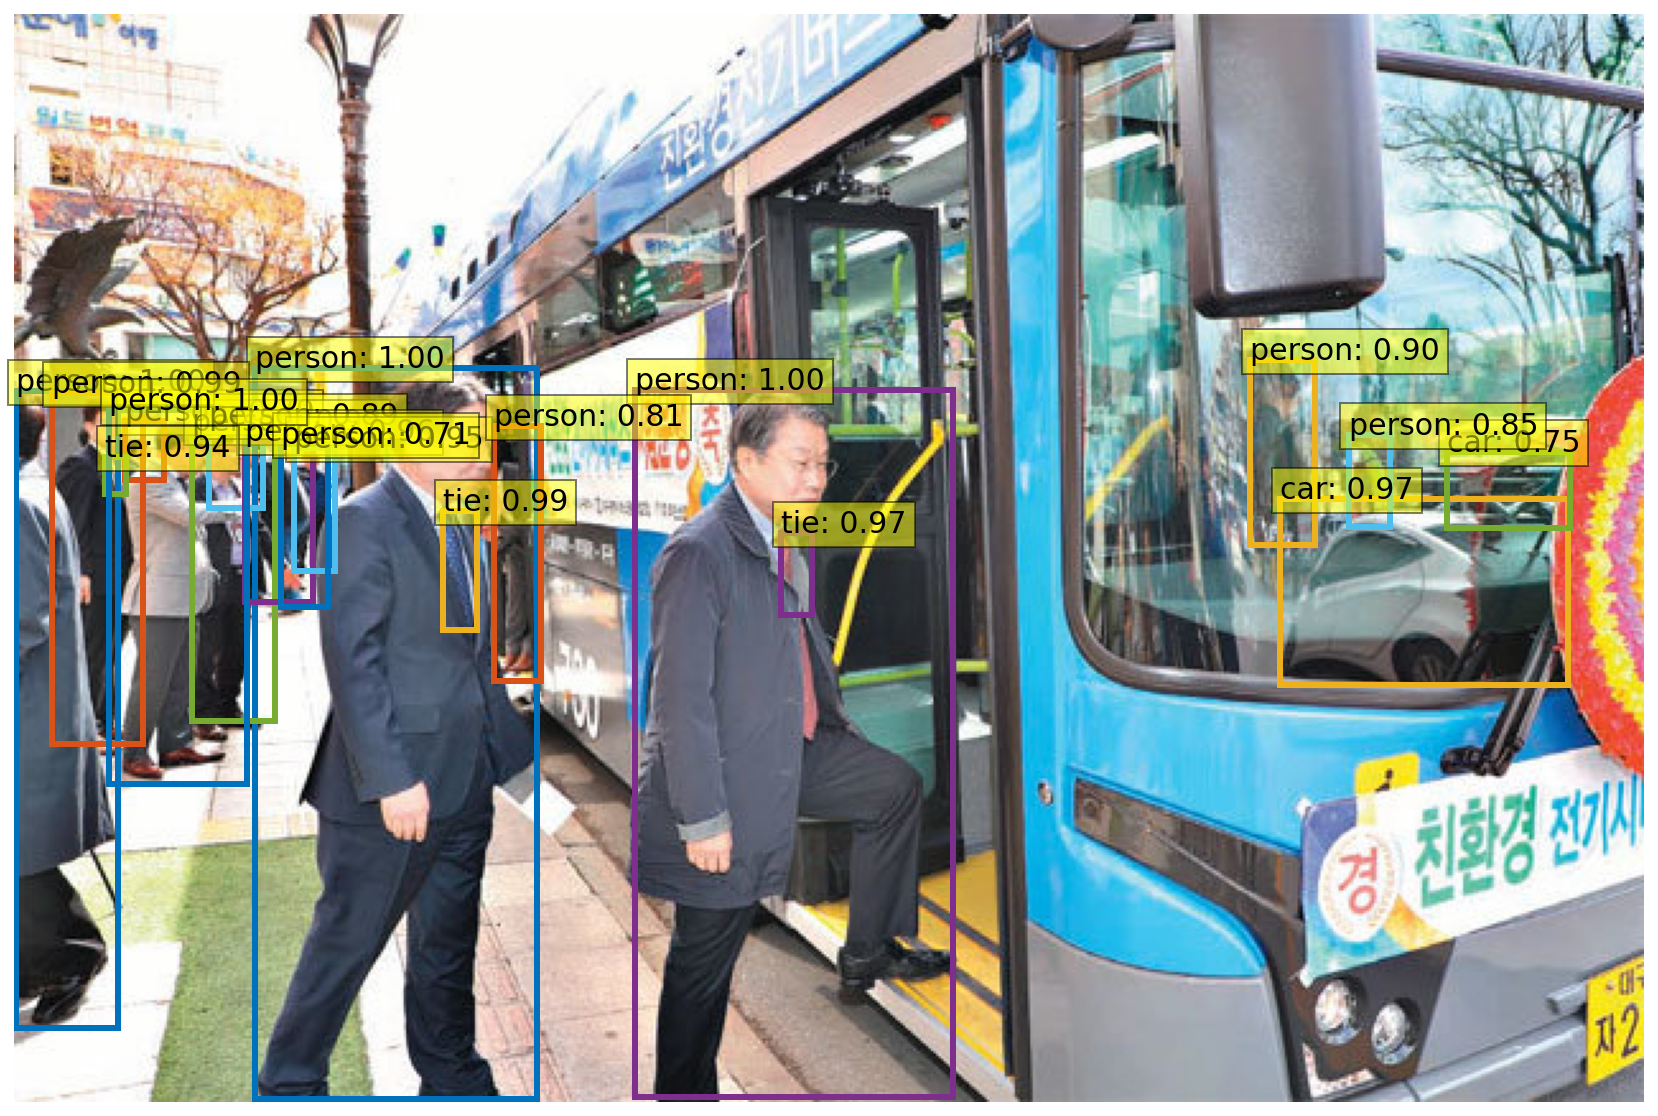

In [22]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize = (16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()

    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill = False, color = c, linewidth = 3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize = 15, bbox = dict(facecolor = 'yellow', alpha = .5))

    plt.axis('off')
    plt.show()

plot_results(im, scores, boxes)

# Detection - TorchHub에 있는 사전학습모델 사용



In [ ]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained = True)
model.eval()

In [24]:
url = 'https://dimg.donga.com/wps/NEWS/IMAGE/2019/03/21/94677873.1.jpg'
im = Image.open(requests.get(url, stream = True).raw)

In [25]:
img = transform(im).unsqueeze(0)

outputs = model(img)

probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


# Detection - 인코더-디코더 multi-head attention 스코어값에 따른 가중치를 시각화해보자

디코더 레이어에 있는 attention weights를 시각화해보자. 각각 감지된 물체들은 특정한 Bbox와 class값을 예측하기위해 찾는다.

In [27]:
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
         model.backbone[-2].register_forward_hook(
             lambda self, input, output : conv_features.append(output)
         ),
         model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
             lambda self, input, output : enc_attn_weights.append(output[1])
         ),
         model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
             lambda self, input, output : dec_attn_weights.append(output[1])
         )
]

# 모델을 통해 순전파
outputs = model(img)

for hook in hooks:
    hook.remove()

# 리스트값들은 더이상 필요없음
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


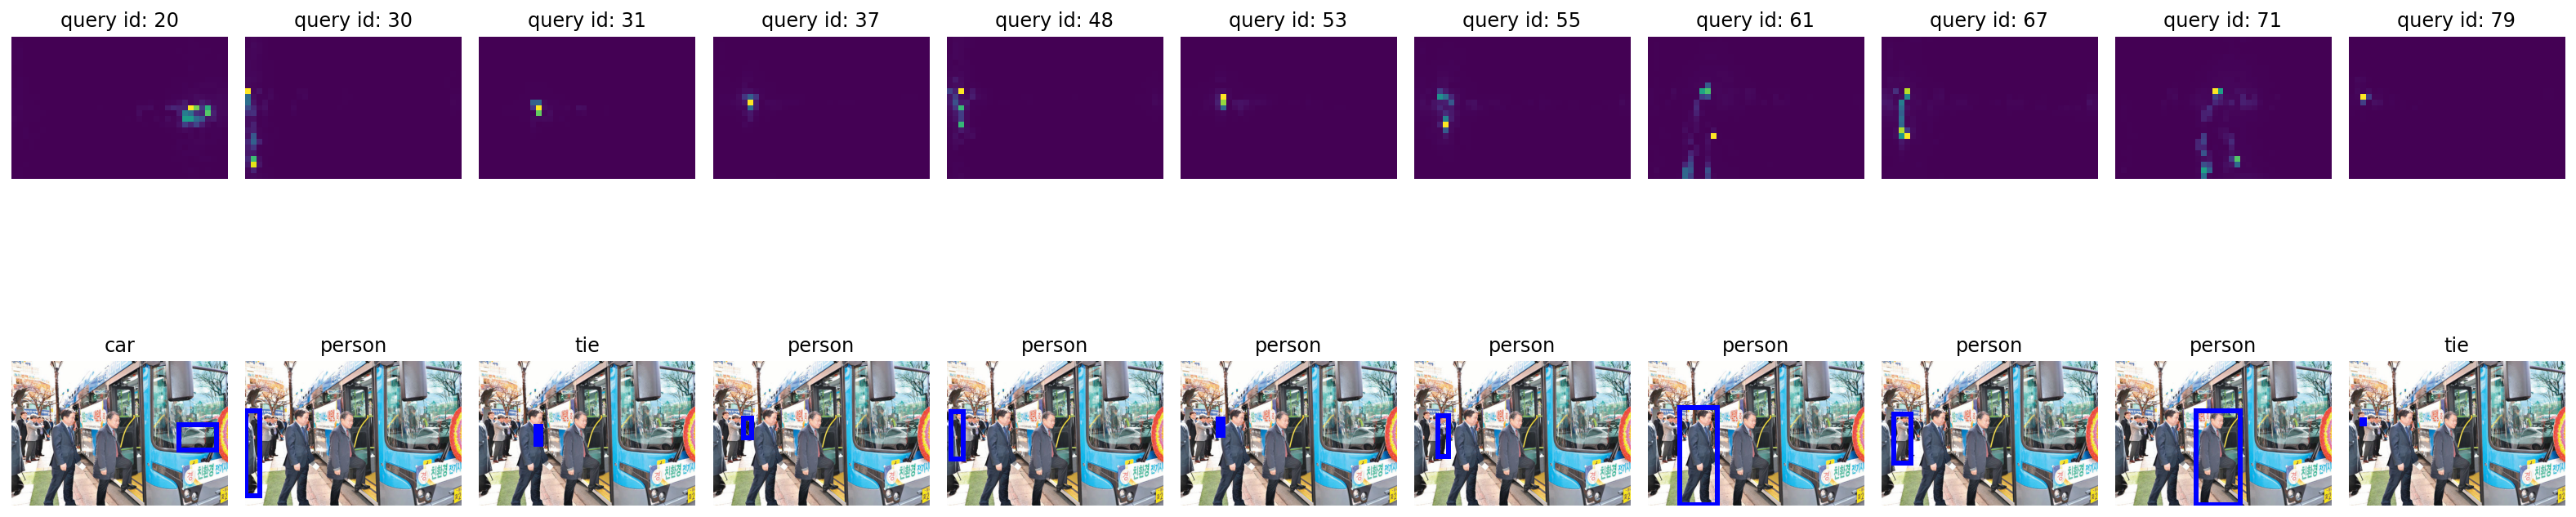

In [29]:
# feature_map의 차원정보를 얻어오자
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols = len(bboxes_scaled), nrows = 2, figsize = (22, 7))
colors = COLORS * 100

for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill = False, color = 'blue', linewidth = 3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])

fig.tight_layout()

# 인코더의 self-attention 가중치들을 시각화해보자

In [30]:
# output of the CNN
f_map = conv_features['0']
print("Encoder attention:      ", enc_attn_weights[0].shape)
print("Feature map:            ", f_map.tensors.shape)

Encoder attention:       torch.Size([950, 950])
Feature map:             torch.Size([1, 2048, 25, 38])


the self-attention is a square matrix of size [H * W, H * W], where H and W are the sizes of the feature map, so we reshape it so that it has a more interpretable representation of [H, W, H, W].

In [31]:
# get the HxW shape of the feature maps of the CNN
shape = f_map.tensors.shape[-2:]
# and reshape the self-attention to a more interpretable shape
sattn = enc_attn_weights[0].reshape(shape + shape)
print("Reshaped self-attention:", sattn.shape)

Reshaped self-attention: torch.Size([25, 38, 25, 38])


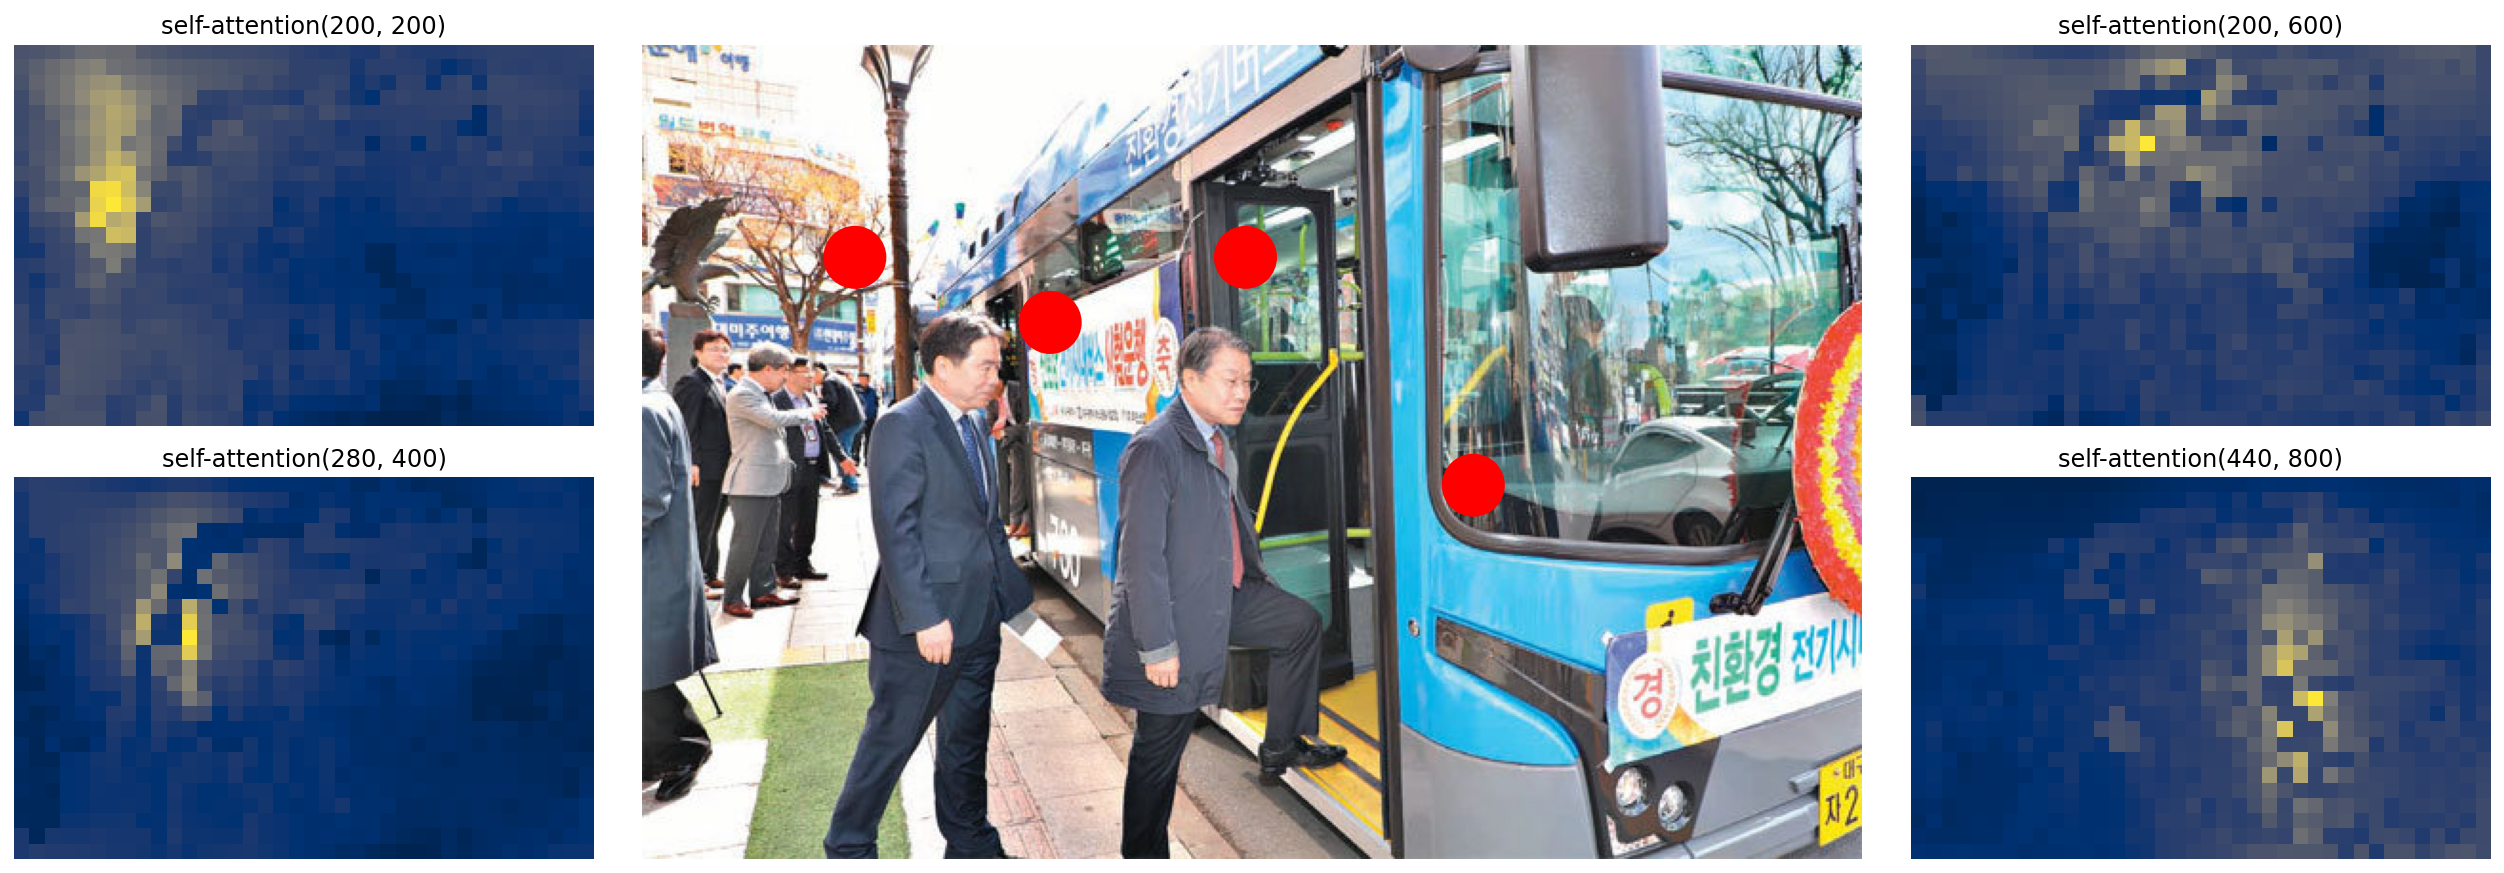

In [32]:
# downsampling factor for the CNN, is 32 for DETR and 16 for DETR DC5
fact = 32

# let's select 4 reference points for visualization
idxs = [(200, 200), (280, 400), (200, 600), (440, 800),]

# here we create the canvas
fig = plt.figure(constrained_layout=True, figsize=(25 * 0.7, 8.5 * 0.7))
# and we add one plot per reference point
gs = fig.add_gridspec(2, 4)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[0, -1]),
    fig.add_subplot(gs[1, -1]),
]

# for each one of the reference points, let's plot the self-attention
# for that point
for idx_o, ax in zip(idxs, axs):
    idx = (idx_o[0] // fact, idx_o[1] // fact)
    ax.imshow(sattn[..., idx[0], idx[1]], cmap='cividis', interpolation='nearest')
    ax.axis('off')
    ax.set_title(f'self-attention{idx_o}')

# and now let's add the central image, with the reference points as red circles
fcenter_ax = fig.add_subplot(gs[:, 1:-1])
fcenter_ax.imshow(im)
for (y, x) in idxs:
    scale = im.height / img.shape[-2]
    x = ((x // fact) + 0.5) * fact
    y = ((y // fact) + 0.5) * fact
    fcenter_ax.add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))
    fcenter_ax.axis('off')